In [11]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import tensorflow as tf
from basenji import seqnn, dataset
from akita_utils.numpy_utils import ut_dense
from akita_utils.plot_utils import plot_map

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# paths to the model and parameters files
main_dir = "/project/fudenber_735/tensorflow_models/akita/v1/"
model_file = main_dir + "model_best.h5"
params_file = main_dir + "params.json"

In [4]:
### load params, specify model ###

with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1048576, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1048576, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1048576, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [5]:
# restore model
seqnn_model.restore(model_file)
print('successfully loaded')

successfully loaded


In [6]:
### names of targets ###
data_dir = main_dir + "data/"

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

## Make predictions for saved tfrecords

In [7]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"

In [8]:
# reading saved V1 sequences
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

# reading overlapped test sequences for Akita V1 and V2
overlap_test = pd.read_csv("./data/v1_v2_sequences.tsv", sep='\t')

# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

In [9]:
# pearson R across the full text set (413 test sequences, Akita V1)
pearR = pearsonr(seqnn_model.model.predict(test_inputs[:,:,:]).flatten(), test_targets[:,:,:].flatten())

13/13 [==============================] - 80s 6s/step


In [10]:
pearR[0]

0.6123774016825304

In [12]:
test_MSE = []
test_Spearman = []

all_preds = []
all_targets = []

for ind, row in overlap_test.iterrows():
    if ind % 10 == 0:
        print(f"Index: {ind}")
    chr, seq_start, seq_end = row.chr, row.start, row.stop
    myseq_str = chr+':'+str(seq_start)+'-'+str(seq_end)
    print("\t - ", myseq_str)

    # find index in the all test sequences
    index = np.where( (all_test_V1_seqs['chr'].values== chr) *
                         (all_test_V1_seqs['start'].values== int(seq_start))*
                         (all_test_V1_seqs['stop'].values==  int(seq_end))  )[0][0] 

    test_target = test_targets[index:index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[index:index+1,:,:])

    all_targets.append(test_target[0,:,:])
    all_preds.append(test_pred[0,:,:])
    
    MSE = [np.mean((test_target[0,:,target_index] - test_pred[0,:,target_index]) ** 2) for target_index in range(test_pred.shape[2])]
    test_MSE.append(MSE)

    spearman = [spearmanr(test_pred[0,:,target_index], test_target[0,:,target_index])[0] for target_index in range(test_pred.shape[2])]
    test_Spearman.append(spearman)
    
    print()

Index: 0
	 -  chr1:72345600-73394176
1/1 [==============================] - 0s 383ms/step

	 -  chr1:72869888-73918464
1/1 [==============================] - 0s 314ms/step

	 -  chr1:73394176-74442752
1/1 [==============================] - 0s 316ms/step

	 -  chr1:73918464-74967040
1/1 [==============================] - 0s 341ms/step

	 -  chr1:74442752-75491328
1/1 [==============================] - 0s 365ms/step

	 -  chr1:74967040-76015616
1/1 [==============================] - 0s 346ms/step

	 -  chr1:75491328-76539904
1/1 [==============================] - 0s 368ms/step

	 -  chr1:76015616-77064192
1/1 [==============================] - 0s 344ms/step

	 -  chr1:76539904-77588480
1/1 [==============================] - 0s 331ms/step

	 -  chr1:109703168-110751744
1/1 [==============================] - 0s 322ms/step

Index: 10
	 -  chr1:110227456-111276032
1/1 [==============================] - 0s 322ms/step

	 -  chr1:110751744-111800320
1/1 [==============================] - 0s 352

In [14]:
overlap_test = overlap_test.copy()

test_MSE_array = np.array(test_MSE)
test_Spearman_array = np.array(test_Spearman)

for target_index in range(5):
    overlap_test.loc[:, f"v1_MSE_{target_index}"] = test_MSE_array[:, target_index]
    overlap_test.loc[:, f"v1_S_{target_index}"] = test_Spearman_array[:, target_index]

# Averaging over targets
overlap_test.loc[:, 'v1_MSE'] = overlap_test[[f"v1_MSE_{target_index}" for target_index in range(5)]].mean(axis=1)
overlap_test.loc[:, 'v1_S'] = overlap_test[[f"v1_S_{target_index}" for target_index in range(5)]].mean(axis=1)

# Saving results
# overlap_test.to_csv("v1_results.tsv", sep="\t", index=False, header=True)

### MSE vs. Spearman Correlation

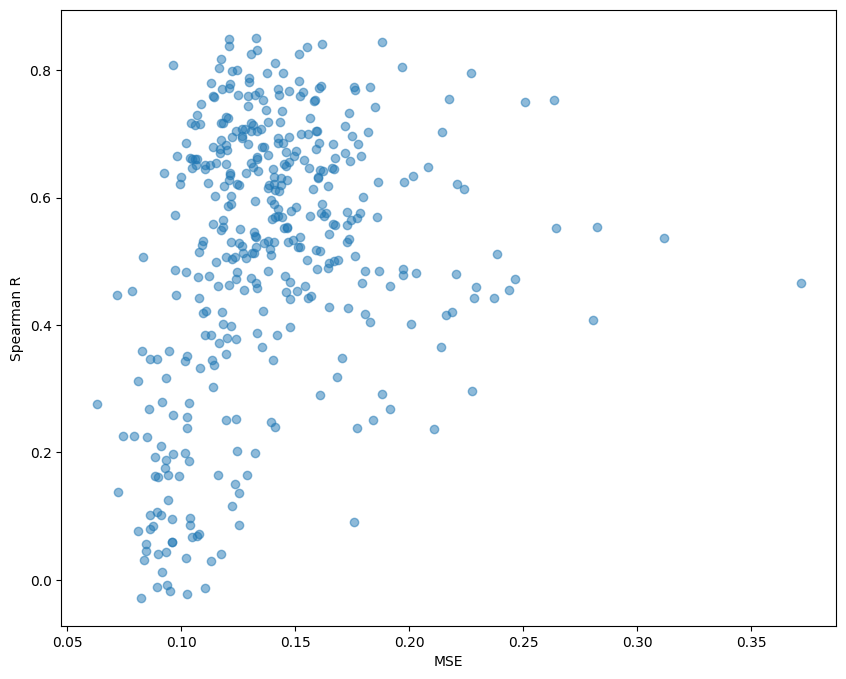

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE"], overlap_test["v1_S"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

plt.show()

### MSE vs. Spearman Correlation for target 0

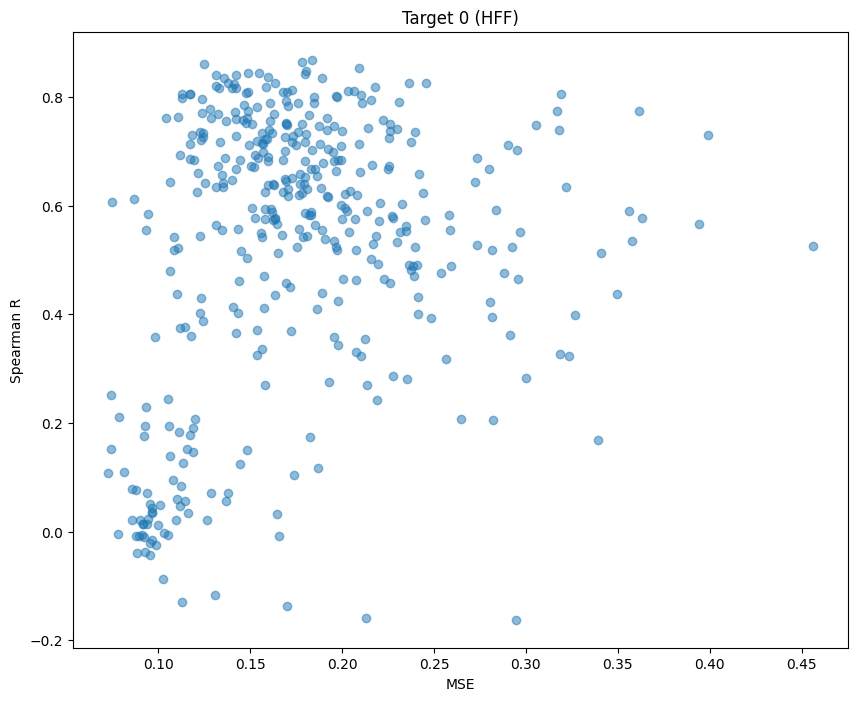

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(overlap_test["v1_MSE_0"], overlap_test["v1_S_0"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

ax.set_title("Target 0 (HFF)")

plt.show()

## Metrics - predictions vs. targets

In [17]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

pearR = pearsonr(all_preds.flatten(), all_targets.flatten())
spearmanR = spearmanr(all_preds.flatten(), all_targets.flatten())
mse = ((all_targets.flatten() - all_preds.flatten()) ** 2).mean()

In [20]:
print("Pearson R = ", pearR[0])
print("Spearnman R = ", spearmanR[0])
print("MSE = ", mse)

Pearson R =  0.6203657089345832
Spearnman R =  0.5605090971875837
MSE =  0.13908249


### Plotting example maps (of no and big prediction improvement)

In [22]:
# point very close to diagonal (no improvement) -> chr1:73918464-74967040
# point with much better performance -> chr9:132390912-133439488

fig_examples = [   'chr1:73918464-74967040',
                    'chr9:132390912-133439488']
fig_inds = []
for seq in fig_examples:
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (all_test_V1_seqs['chr'].values== chrm) *
                         (all_test_V1_seqs['start'].values== int(start))*
                         (all_test_V1_seqs['stop'].values==  int(stop ))  )[0][0]
    fig_inds.append(test_ind)

 
chr1:73918464-74967040
1/1 [==============================] - 0s 364ms/step
target: 


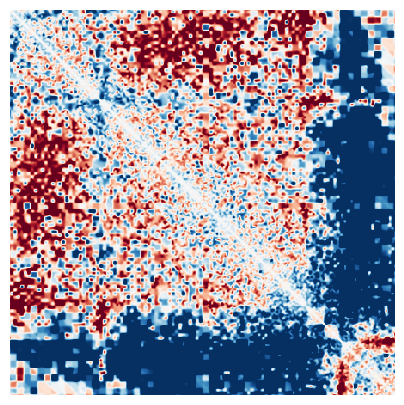

prediction: 


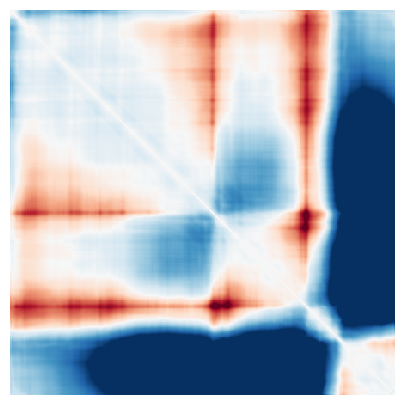

 
chr9:132390912-133439488
1/1 [==============================] - 0s 316ms/step
target: 


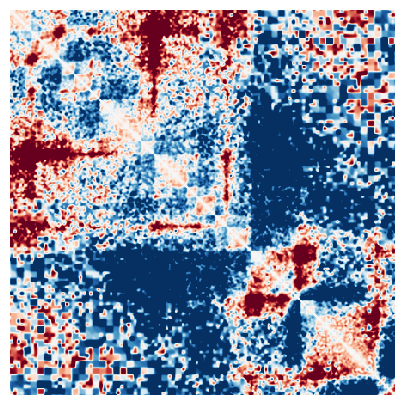

prediction: 


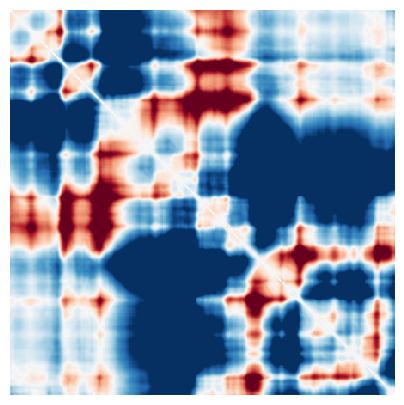

In [23]:
# make predictions and plot the examples above

# target to save
target_index = 0

for test_index in fig_inds:
    chrm, seq_start, seq_end = all_test_V1_seqs.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[test_index:test_index+1,:,:])

    test_target_maps = ut_dense(test_target[0,:,:])
    test_pred_maps = ut_dense(test_pred[0,:,:])

    # # maps averaged over all targets
    # ave_test_target_maps = np.mean(test_target_maps, axis=2)
    # ave_test_pred_maps = np.mean(test_pred_maps, axis=2)
    
    
    # saving prediction
    # np.savez(f'./matrices/{myseq_str}_map_v1_tg0.npz', prediction=test_pred_maps[:,:,target_index])
    
    # print("target: ")
    # plot_map(ave_test_target_maps) #vmin=-2, vmax=2)
    # print("prediction: ")
    # plot_map(ave_test_pred_maps) #vmin=-2, vmax=2)

    print("target: ")
    plot_map(test_target_maps[:,:,target_index])
    print("prediction: ")
    plot_map(test_pred_maps[:,:,target_index])